#  **DECISION TREE FOR BREAST CANCER DATASET**
---

Import necessary library

In [7]:
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image

%matplotlib inline

## 1. EXPLORE DATASET

### 1.1 Load dataset

In [8]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

df = pd.DataFrame(X)

# Get feature names and target names
feature_names = X.columns.to_numpy()
target_names = np.unique(y)
target_names_mapping = {
    0: "Malignant",
    1: "Benign"
}

# Convert features and targets to NumPy arrays
X = X.to_numpy()
y = y.to_numpy().flatten()
y = np.where(y == 'M', 0, 1)

df.head()

radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60  2019.0       0.1622        0.6656      0.7119   
1     23.41      158.80  1956.0       0.1238        0.1866      0.2416   
2     25.53      152.50  1709.0       0.1444        0.4245      0.4504   
3     26.50       98.87   567.7       0.2098        0.8663      0.6869   
4     16.67      152.20  1575.0       0.1374        0.2050      0.4000   

   concave_points3  symmetry3  fractal_dimension3  
0           0.2654     0.4601             0.11890  
1           0.1860     0.2750             0.08902  
2           0.2430     0.3613             0.08758  
3           0.2575     0.6638             0.17300  
4           0.1625     0.2364             0.07678  

[5 rows x 30 columns]

### 1.2 Explore dataset

#### a) Number of rows and columns

In [9]:
df.shape

(569, 30)

#### b) Variable infomations

- Each line of data in the breast cancer dataset corresponds to a sample, specifically information about a breast tumor. This information includes the following variables.

In [10]:
df_info = pd.DataFrame(breast_cancer_wisconsin_diagnostic.variables)
df_info

name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        None  None   
12             radius2  Feature   Continuous        None        None  None   
13            texture2  Feature   Continuous        None        None  None   
14          perimeter2  Feature   Continuous        None        None  None   
15               area2  Feature   Continuous        None        None  None   
16         smoothness2  Feature   Continuous        None        None  None   
17        compactness2  Feature   Continuous        None        None  None   
18          concavity2  Feature   Continuous        None        None  None   
19     concave_points2  Feature   Continuous        None        None  None   
20           symmetry2  Feature   Continuous        None        None  None   
21  fractal_dimension2  Feature   Continuous        None        None  None   
22             radius3  Feature   Continuous        None        None  None   
23            texture3  Feature   Continuous        None        None  None   
24          perimeter3  Feature   Continuous        None        None  None   
25               area3  Feature   Continuous        None        None  None   
26         smoothness3  Feature   Continuous        None        None  None   
27        compactness3  Feature   Continuous        None        None  None   
28          concavity3  Feature   Continuous        None        None  None   
29     concave_points3  Feature   Continuous        None        None  None   
30           symmetry3  Feature   Continuous        None        None  None   
31  fractal_dimension3  Feature   Continuous        None        None  None   

   missing_values  
0              no  
1              no  
2              no  
3              no  
4              no  
5              no  
6              no  
7              no  
8              no  
9              no  
10             no  
11             no  
12             no  
13             no  
14             no  
15             no  
16             no  
17             no  
18             no  
19             no  
20             no  
21             no  
22             no  
23             no  
24             no  
25             no  
26             no  
27             no  
28             no  
29             no  
30             no  
31             no

- Comment: 

    + All features are of the Continuous type. 
    
    + The presence of features such as radius1, radius2, and radius3 ... indicates that each tumor can be assessed through multiple levels and different analytical approaches. 
    
    + The data has no missing values and is ready for analysis.

## 2. SPLIT DATA INTO TRAIN/TEST SETS

In [11]:
ratios = [0.4, 0.6, 0.8, 0.9] # train ratio
datasets = {}

value_count = dict(zip(*np.unique(y, return_counts=True)))
class_distributions = {'original': list(value_count.values())}

In [12]:
def split_train_test(X, y, ratio, stratify=True):
    if stratify:
        stratify_param = y
    else:
        stratify_param = None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - ratio, random_state=42, stratify=stratify_param
    )

    return X_train, X_test, y_train, y_test

In [13]:
for ratio in ratios:
    X_train, X_test, y_train, y_test = split_train_test(X, y, ratio)
    datasets[f'{int(ratio*100)}_train'] = (X_train, y_train)
    datasets[f'{100 - int(ratio*100)}_test'] = (X_test, y_test)

    train_counts = dict(zip(*np.unique(y_train, return_counts=True)))
    test_counts = dict(zip(*np.unique(y_test, return_counts=True)))    
    class_distributions[f'{int(ratio*100)}_train'] = list(train_counts.values())
    class_distributions[f'{100 - int(ratio*100)}_test'] = list(test_counts.values())

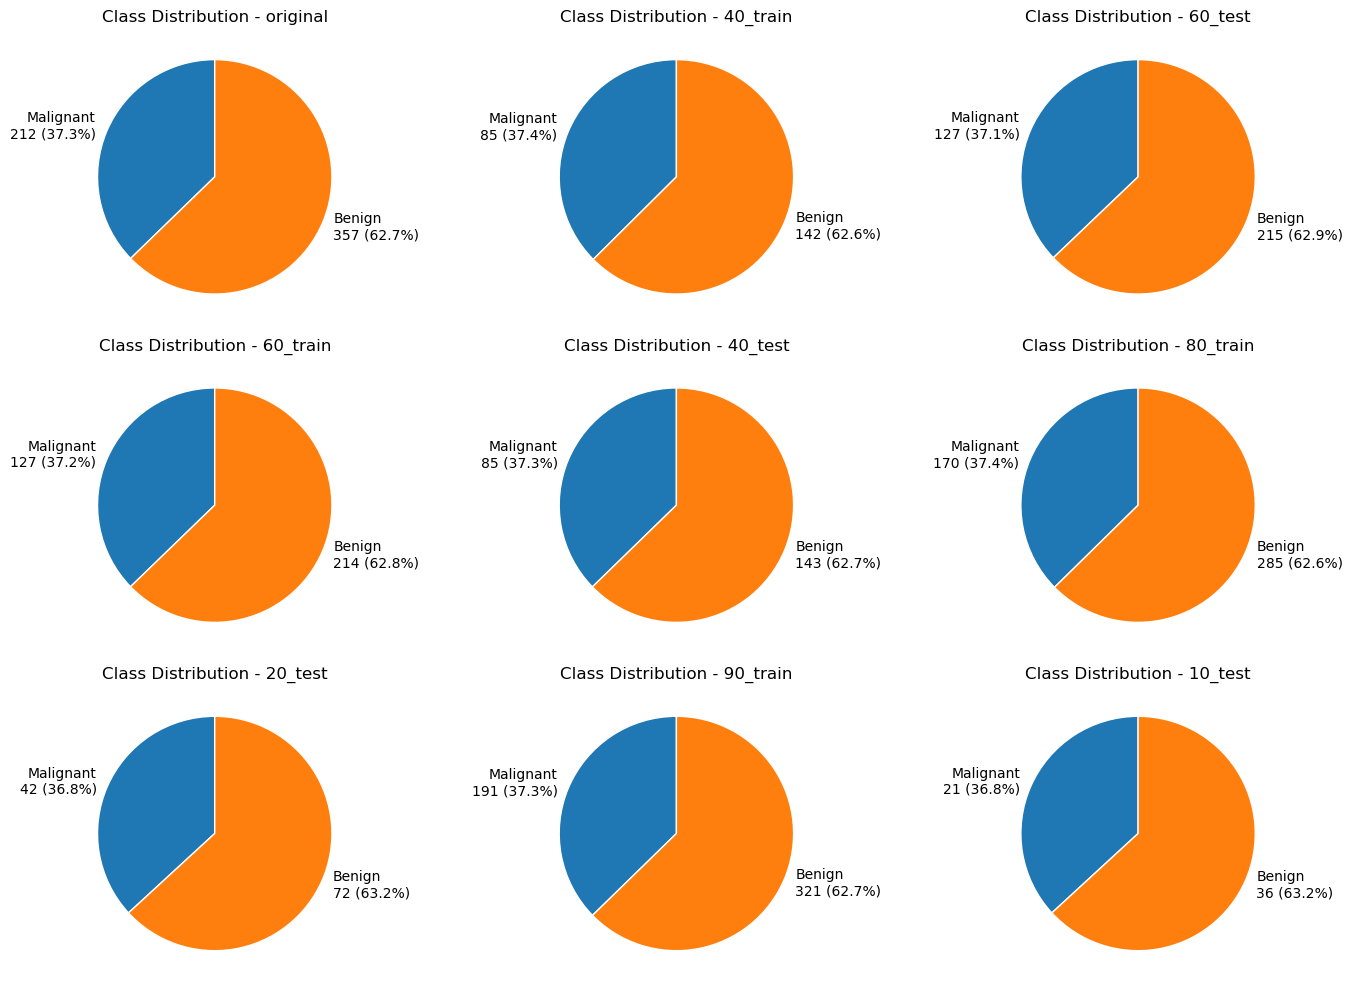

In [14]:
plt.figure(figsize=(14, 10))

for i, (key, y_values) in enumerate(class_distributions.items()):
    plt.subplot(3, 3, i + 1)
    
    total = sum(y_values)
    labels = [f"{target_names_mapping[idx]}\n{count} ({count / total:.1%})" 
              for idx, count in enumerate(y_values)] 
    
    plt.pie(
        y_values,
        labels=labels,
        autopct=None, 
        colors=["#1f77b4", "#ff7f0e"],  
        startangle=90,
        wedgeprops={"edgecolor": "white", "linewidth": 1}  
    )
    plt.title(f"Class Distribution - {key}")

plt.tight_layout();

- The distribution of the data after splitting is nearly identical to the original distribution, indicating that the data splitting has preserved the representativeness of the original dataset. We can go the the next step.

## 3. BUILD DECISION TREE AND VISUALIZE

In [15]:
# Folder to save the decision tree images of all 4 test datasets.
save_folder = "./Image4Datasets/"

### 3.1 40/60-TRAIN/TEST DATASET

#### a) Create decision tree

In [16]:
X_train_40 = datasets['40_train'][0]
y_train_40 = datasets['40_train'][1]
X_test_60 = datasets['60_test'][0]
y_test_60 = datasets['60_test'][1]

dt_60_test = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_60_test.fit(X_train_40, y_train_40)
y_predict_60 = dt_60_test.predict(X_test_60)

#### b) Visualize

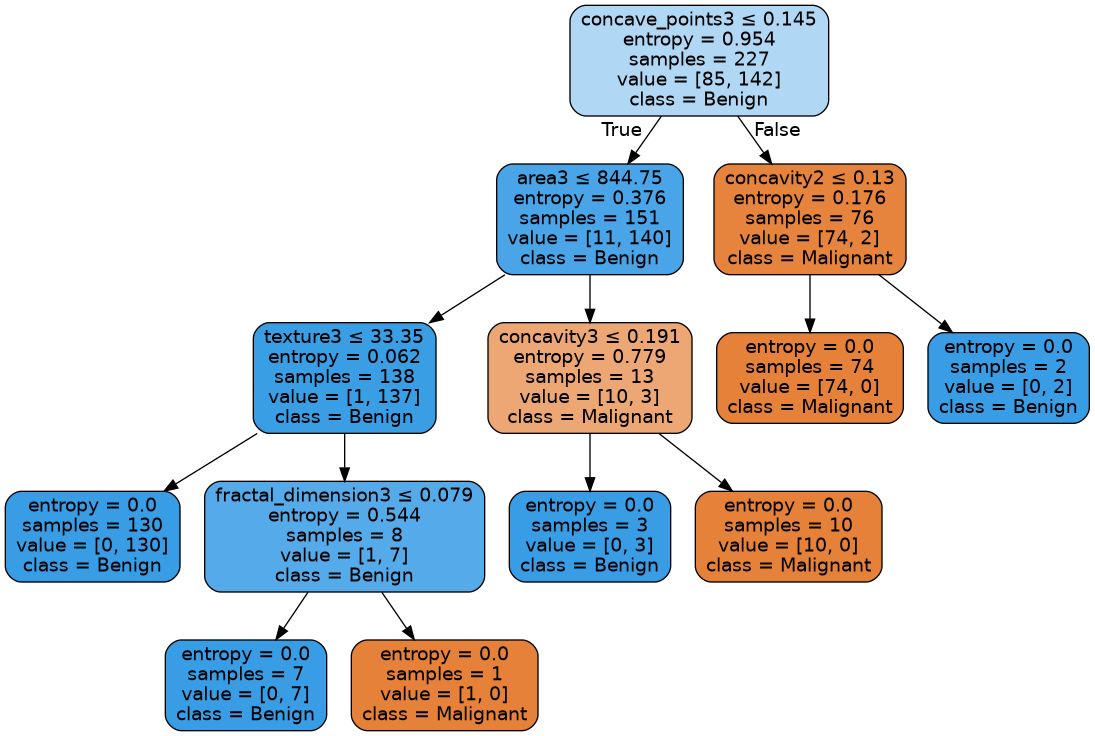

In [17]:
dot_60_test = export_graphviz(
    dt_60_test, 
    out_file=None, 
    feature_names=feature_names,  
    class_names=target_names_mapping,   
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_60_test)
graph.render(save_folder+ "DT_60_test", format="png", cleanup=True)
display(Image(save_folder+"DT_60_test.png"))

#### c) Evaluate the decision tree classifiers

- Classification Report

In [18]:
report_60_test = classification_report(y_predict_60, y_test_60, target_names=target_names)
print("\nClassification Report:")
print(report_60_test)


Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.86      0.89       135
           M       0.91      0.95      0.93       207

    accuracy                           0.91       342
   macro avg       0.91      0.90      0.91       342
weighted avg       0.91      0.91      0.91       342



- Confusion matrix:

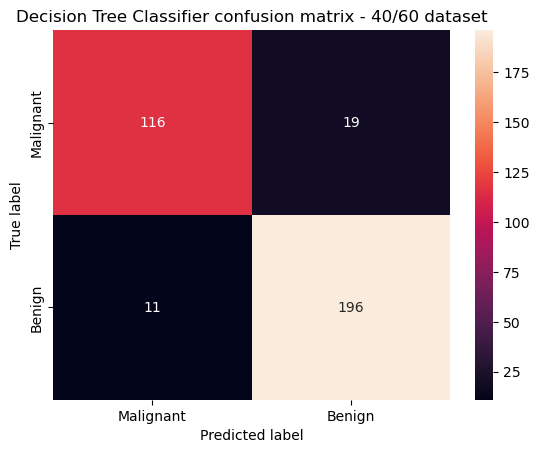

In [19]:
cf_60_test = confusion_matrix(y_predict_60, y_test_60)

sns.heatmap(
    cf_60_test, 
    annot=True, 
    fmt = 'd', 
    xticklabels=target_names_mapping.values(), 
    yticklabels=target_names_mapping.values()
    )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Decision Tree Classifier confusion matrix - 40/60 dataset");

### 3.2 60/40-TRAIN/TEST DATASET

#### a) Create decision tree

In [20]:
X_train_60 = datasets['60_train'][0]
y_train_60 = datasets['60_train'][1]
X_test_40 = datasets['40_test'][0]
y_test_40 = datasets['40_test'][1]

dt_40_test = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_40_test.fit(X_train_60, y_train_60)
y_predict_40 = dt_40_test.predict(X_test_40)

#### b) Visualize

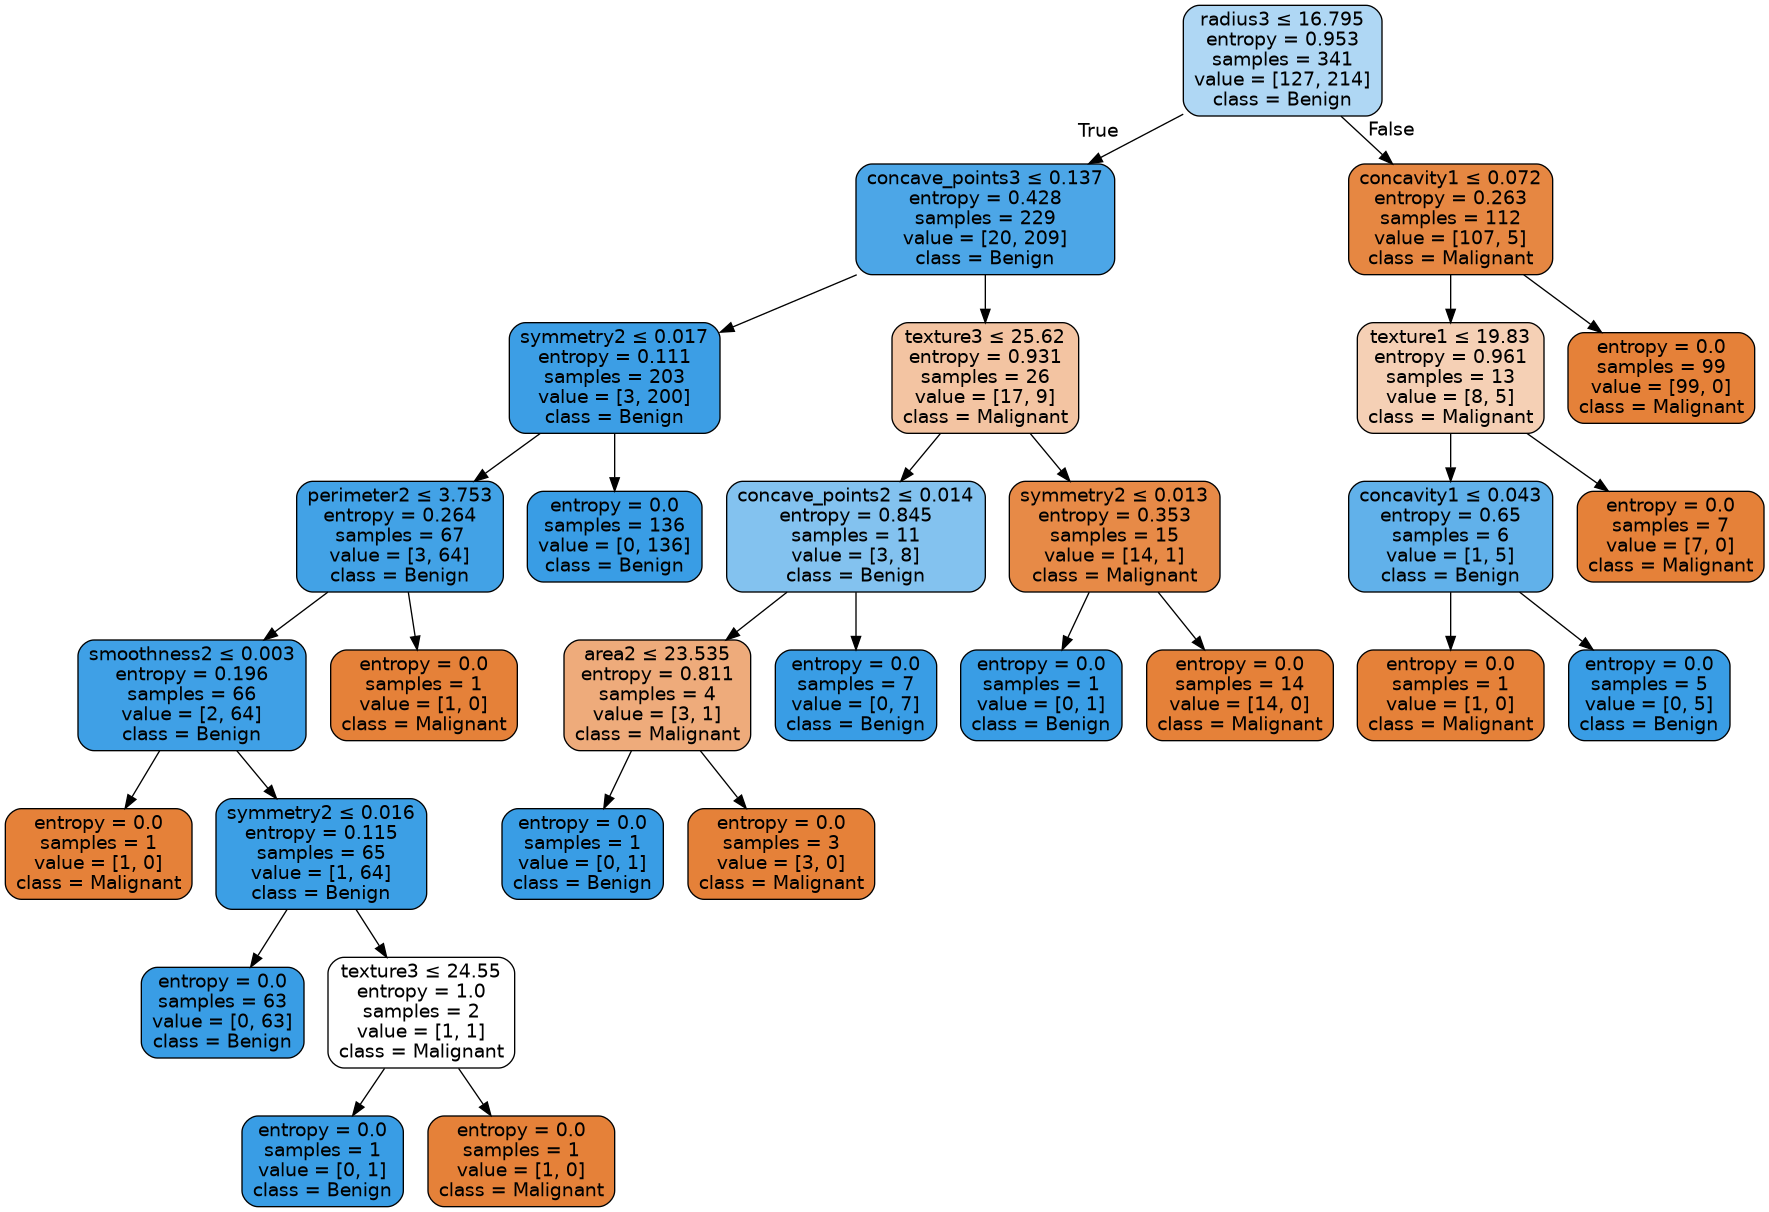

In [21]:
dot_40_test = export_graphviz(
    dt_40_test, 
    out_file=None, 
    feature_names=feature_names,  
    class_names=target_names_mapping, 
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_40_test)
graph.render(save_folder+ "DT_40_test", format="png", cleanup=True)
display(Image(save_folder+"DT_40_test.png"))

#### c) Evaluate the decision tree classifiers

- Classification report

In [22]:
report_40_test = classification_report(y_predict_40, y_test_40, target_names=target_names)
print("\nClassification Report:")
print(report_40_test)


Classification Report:
              precision    recall  f1-score   support

           B       0.93      0.90      0.91        88
           M       0.94      0.96      0.95       140

    accuracy                           0.93       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.93      0.93      0.93       228



- Confusion matrix

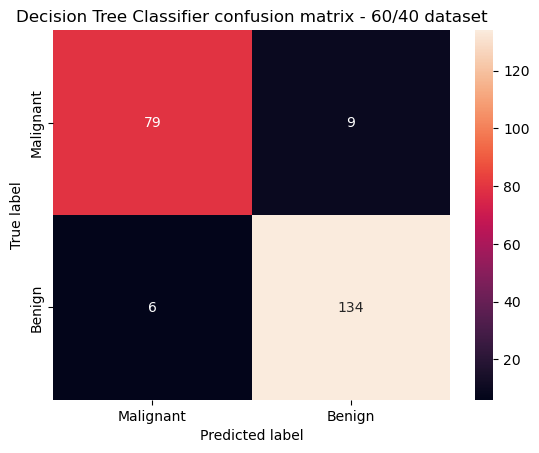

In [23]:
cf_40_test = confusion_matrix(y_predict_40, y_test_40)

sns.heatmap(
    cf_40_test, 
    annot=True, 
    fmt = 'd', 
    xticklabels=target_names_mapping.values(), 
    yticklabels=target_names_mapping.values()
    )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Decision Tree Classifier confusion matrix - 60/40 dataset");

### 3.3 80/20-TRAIN/TEST DATASET

#### a) Create decision tree

In [24]:
X_train_80 = datasets['80_train'][0]
y_train_80 = datasets['80_train'][1]
X_test_20 = datasets['20_test'][0]
y_test_20 = datasets['20_test'][1]

dt_20_test = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_20_test.fit(X_train_80, y_train_80)
y_predict_20 = dt_20_test.predict(X_test_20)

#### b) Visualize

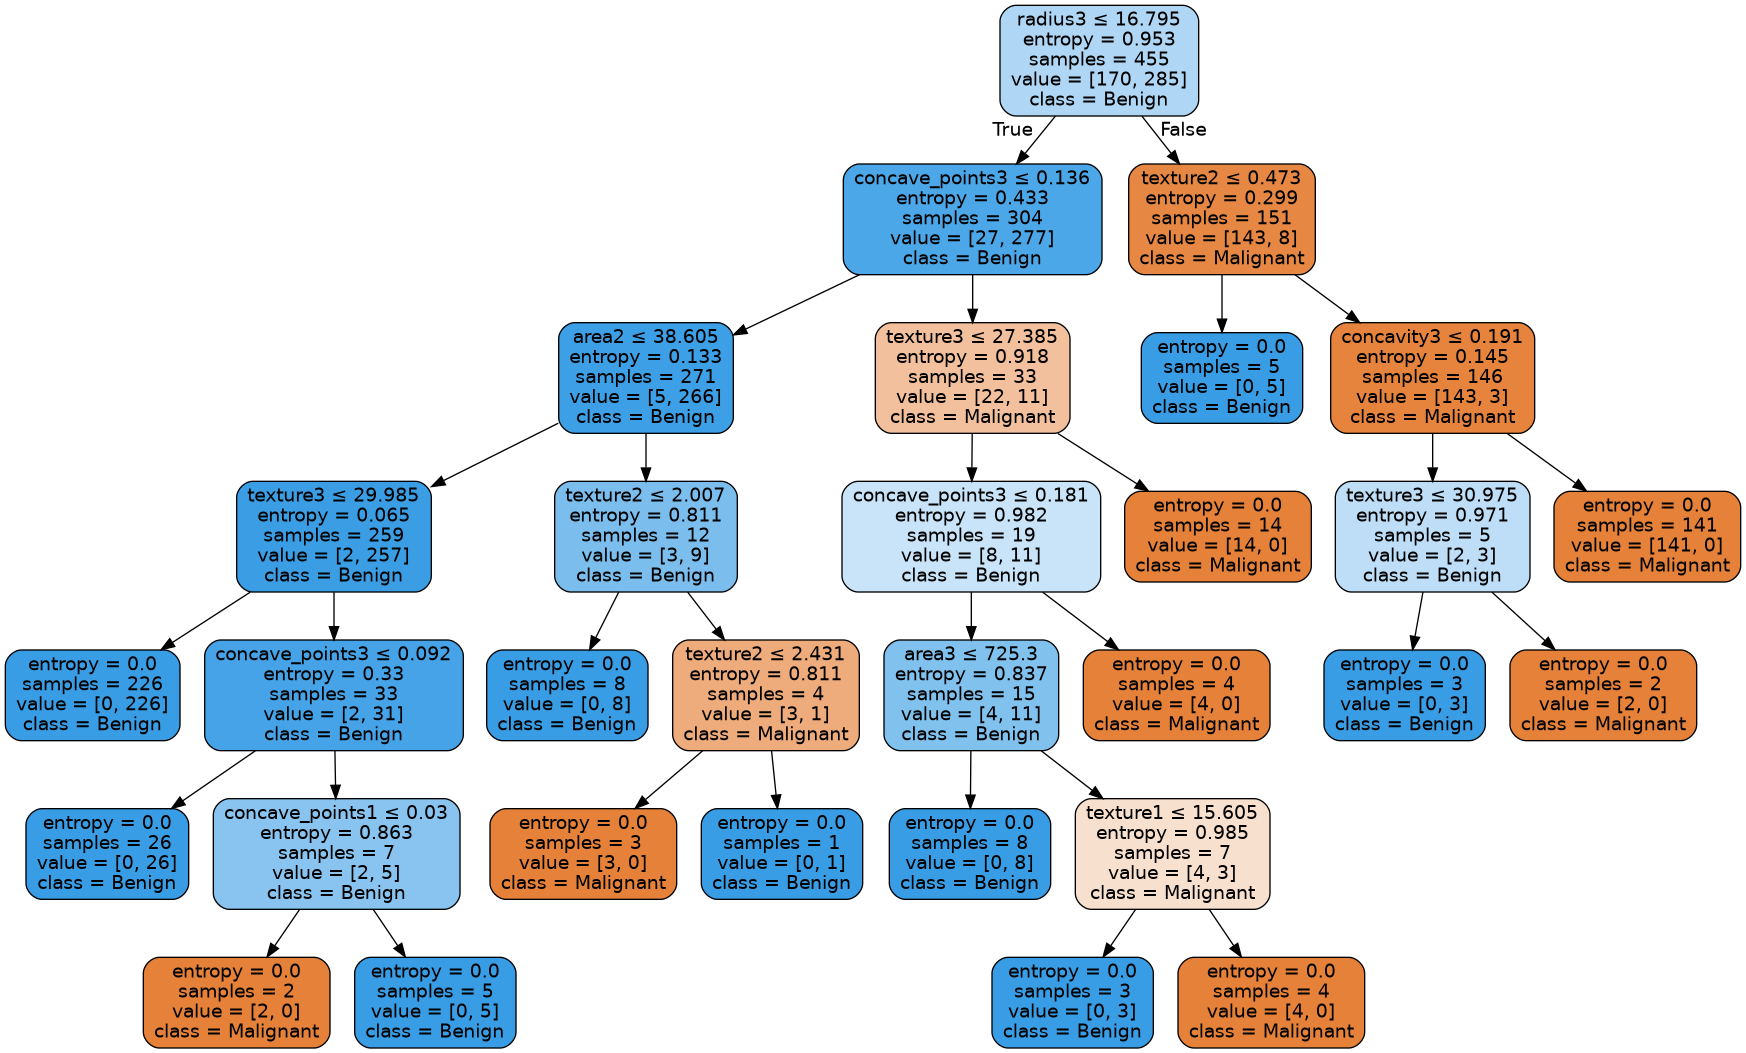

In [25]:
dot_20_test = export_graphviz(
    dt_20_test, 
    out_file=None, 
    feature_names=feature_names, 
    class_names=target_names_mapping,
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_20_test)
graph.render(save_folder+ "DT_20_test", format="png", cleanup=True)
display(Image(save_folder+"DT_20_test.png"))

#### c) Evaluate the decision tree classifiers

- Classification report

In [26]:
report_20_test = classification_report(y_predict_20, y_test_20, target_names=target_names)
print("\nClassification Report:")
print(report_20_test)


Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.83      0.89        48
           M       0.89      0.97      0.93        66

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.92      0.91      0.91       114



- Confusion matrix

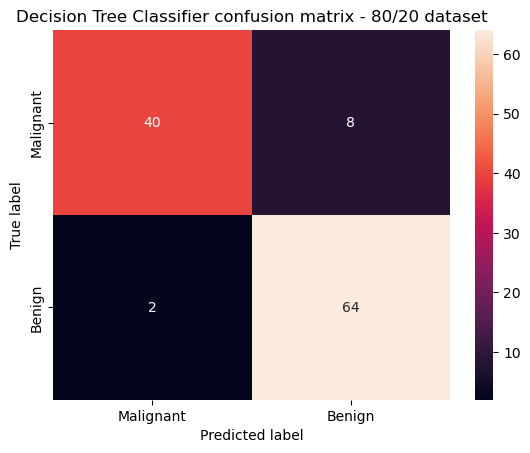

In [27]:
cf_20_test = confusion_matrix(y_predict_20, y_test_20)

sns.heatmap(
    cf_20_test, 
    annot=True, 
    fmt = 'd', 
    xticklabels=target_names_mapping.values(), 
    yticklabels=target_names_mapping.values()
    )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Decision Tree Classifier confusion matrix - 80/20 dataset");

### 3.4 90/10-TRAIN/TEST DATASET

#### a) Create decision tree

In [28]:
X_train_90 = datasets['90_train'][0]
y_train_90 = datasets['90_train'][1]
X_test_10 = datasets['10_test'][0]
y_test_10 = datasets['10_test'][1]

dt_10_test = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_10_test.fit(X_train_90, y_train_90)
y_predict_10 = dt_10_test.predict(X_test_10)

#### b) Visualize

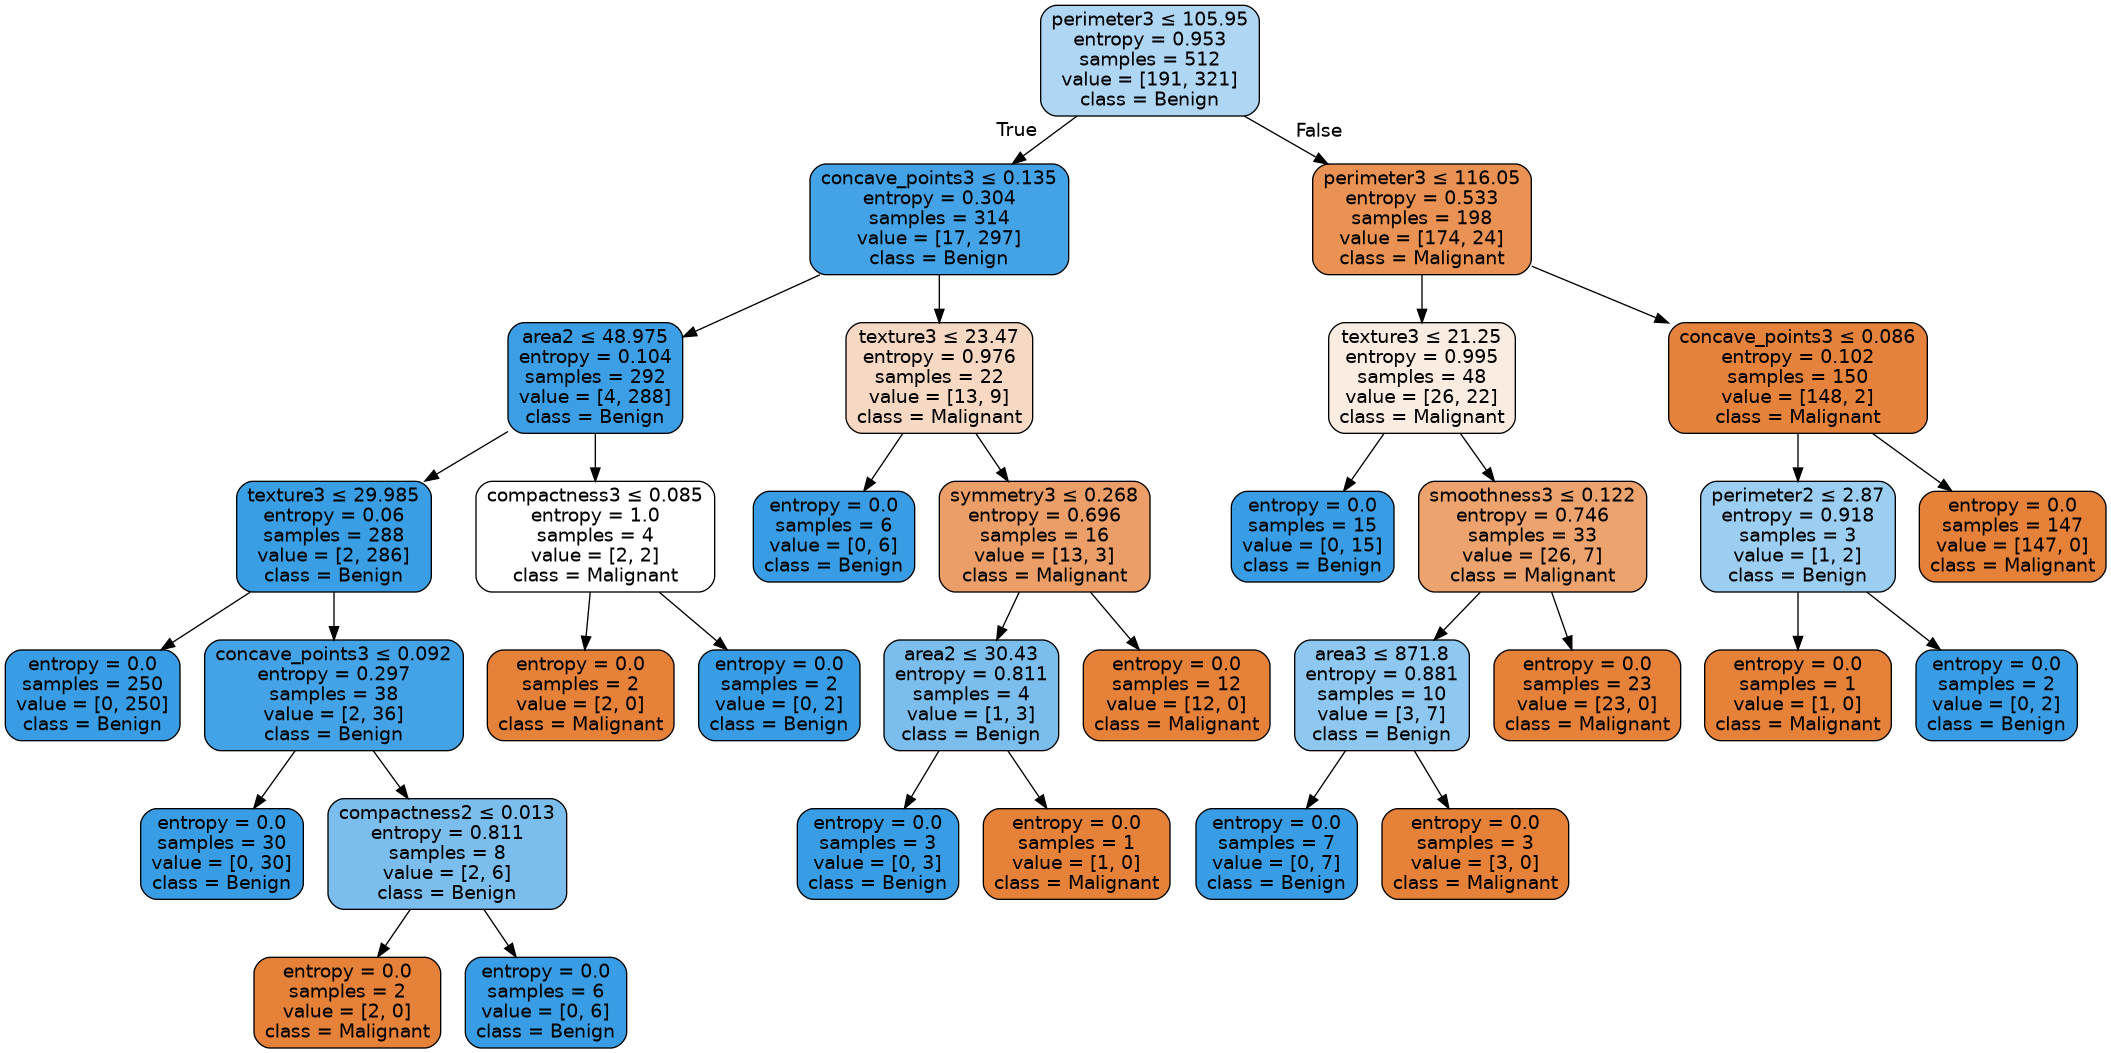

In [29]:
dot_10_test = export_graphviz(
    dt_10_test, 
    out_file=None, 
    feature_names=feature_names, 
    class_names=target_names_mapping,
    filled=True, 
    rounded=True, 
    special_characters=True
)

graph = graphviz.Source(dot_10_test)
graph.render(save_folder+ "DT_10_test", format="png", cleanup=True)
display(Image(save_folder+"DT_10_test.png"))

#### c) Evaluate the decision tree classifiers

- Classsification report

In [30]:
report_10_test = classification_report(y_predict_10, y_test_10, target_names=target_names)
print("\nClassification Report:")
print(report_10_test)


Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.77      0.85        26
           M       0.83      0.97      0.90        31

    accuracy                           0.88        57
   macro avg       0.89      0.87      0.87        57
weighted avg       0.89      0.88      0.88        57



- Confusion matrix

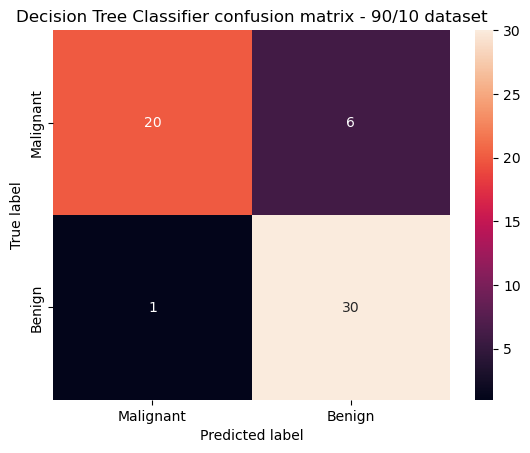

In [31]:
cf_10_test = confusion_matrix(y_predict_10, y_test_10)

sns.heatmap(
    cf_10_test, 
    annot=True, 
    fmt = 'd', 
    xticklabels=target_names_mapping.values(), 
    yticklabels=target_names_mapping.values()
    )
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Decision Tree Classifier confusion matrix - 90/10 dataset");

### 3.5 VISUALIZE THE CHANGE IN 4 TRAIN/TEST RATIOS

#### a) Create data from classification reports

In [32]:
precision_B = [0.91, 0.93, 0.95, 0.95]
precision_M = [0.91, 0.94, 0.89, 0.83]

recall_B = [0.86, 0.90, 0.83, 0.77]
recall_M = [0.95, 0.96, 0.97, 0.97]

accuracies = [0.91, 0.93, 0.91, 0.88]
f1_scores_weighted = [0.91, 0.93, 0.91, 0.88]

labels = ['40/60', '60/40', '80/20', '90/10']

#### b) Visualize

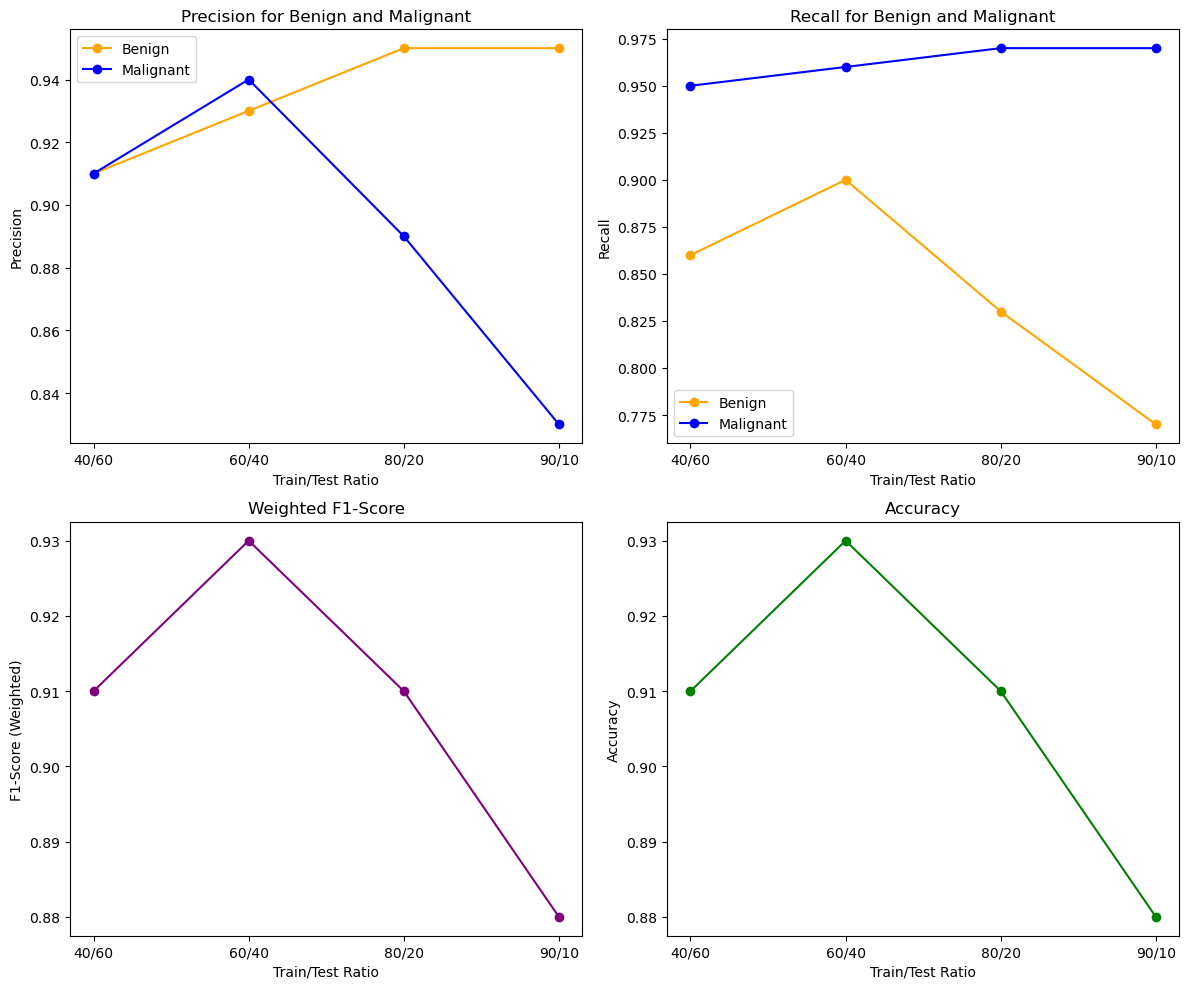

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Precision
axes[0, 0].plot(labels, precision_B, label='Benign', marker='o', color='orange')
axes[0, 0].plot(labels, precision_M, label='Malignant', marker='o', color='blue')
axes[0, 0].set_title('Precision for Benign and Malignant')
axes[0, 0].set_xlabel('Train/Test Ratio')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].legend()

# Recall
axes[0, 1].plot(labels, recall_B, label='Benign', marker='o', color='orange')
axes[0, 1].plot(labels, recall_M, label='Malignant', marker='o', color='blue')
axes[0, 1].set_title('Recall for Benign and Malignant')
axes[0, 1].set_xlabel('Train/Test Ratio')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].legend()

# F1-Score (Weighted)
axes[1, 0].plot(labels, f1_scores_weighted, label='Weighted F1-Score', marker='o', color='purple')
axes[1, 0].set_title('Weighted F1-Score')
axes[1, 0].set_xlabel('Train/Test Ratio')
axes[1, 0].set_ylabel('F1-Score (Weighted)')

# Accuracy
axes[1, 1].plot(labels, accuracies, label='Accuracy', marker='o', color='green')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Train/Test Ratio')
axes[1, 1].set_ylabel('Accuracy')

plt.tight_layout();

## 4. DEPTH & ACCURACY OF 80/20-TRAIN/TEST DECISION TREE

### a) Create and Visualize the tree for each max_depth

max_depth: None


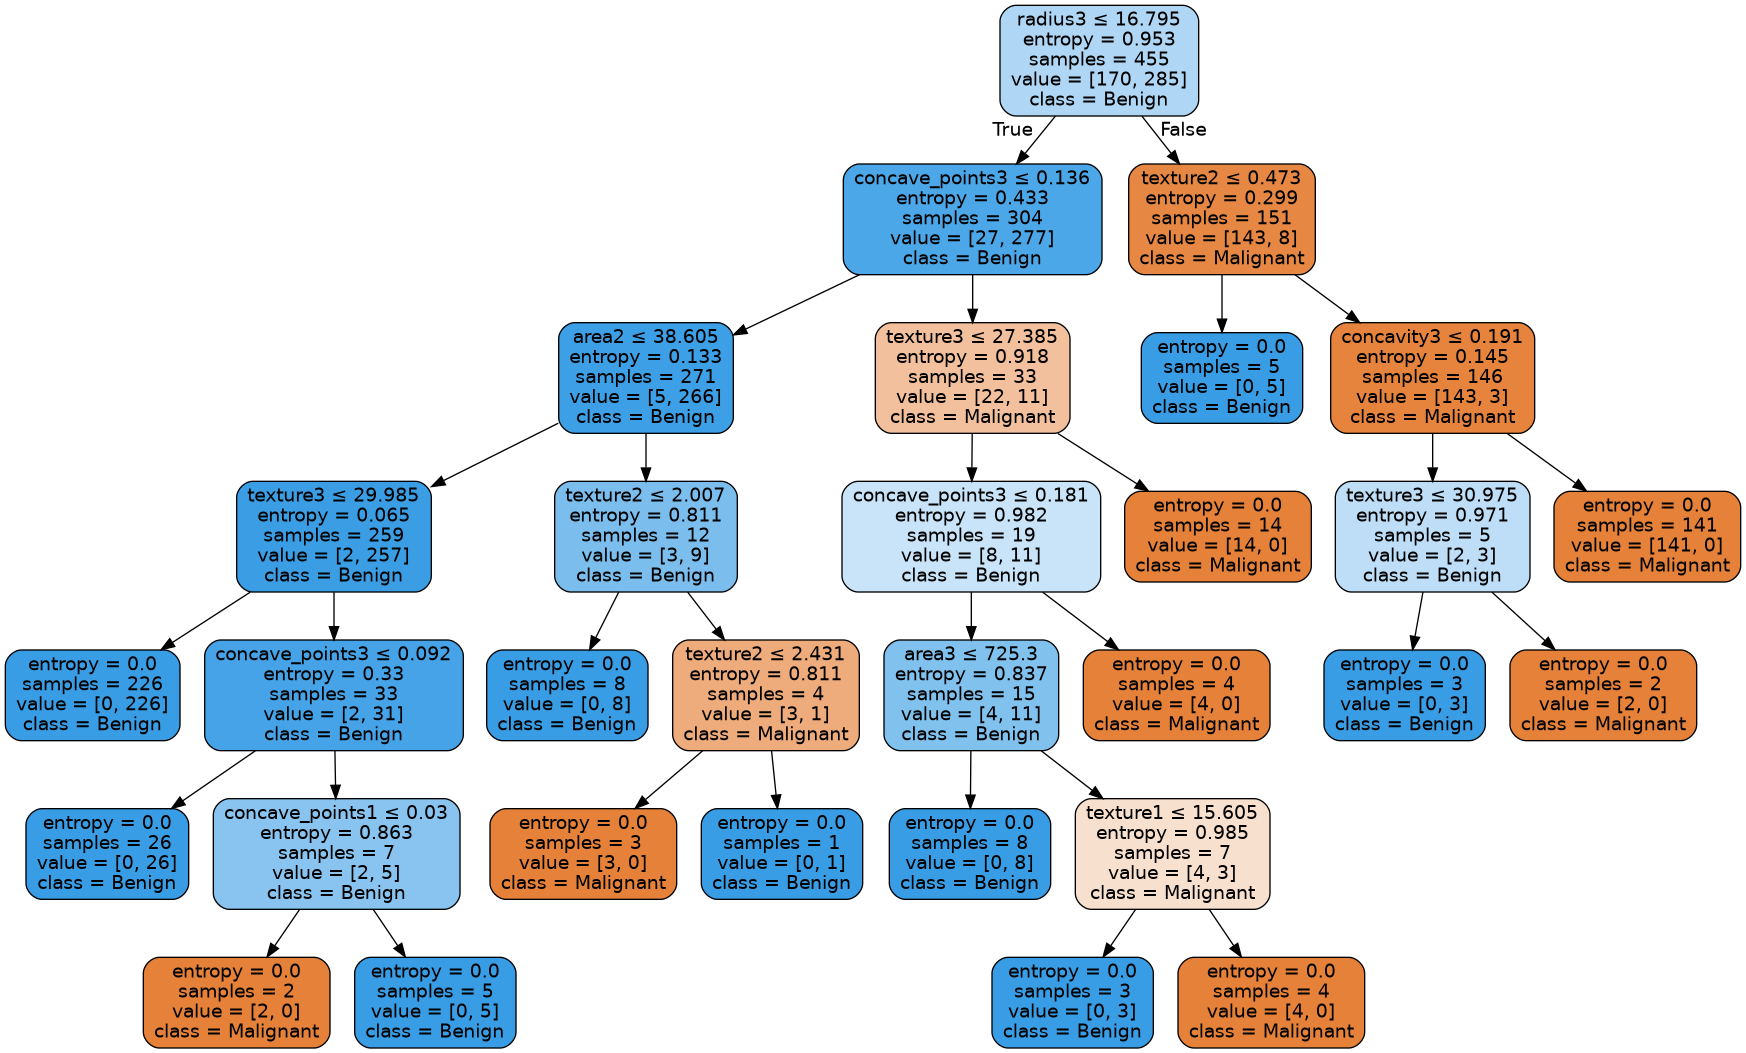

max_depth: 2


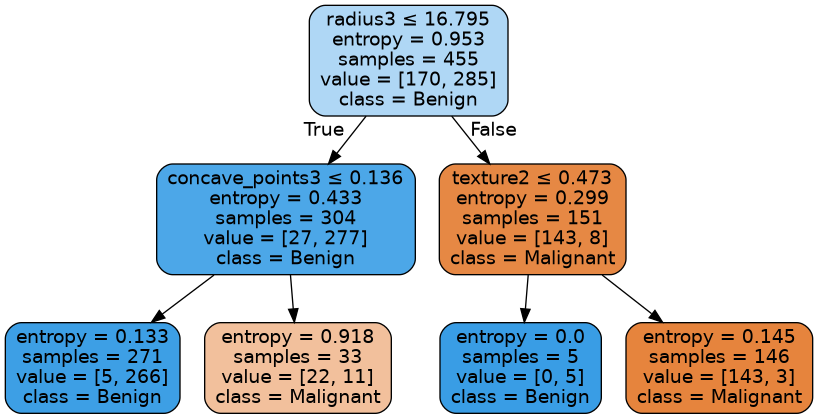

max_depth: 3


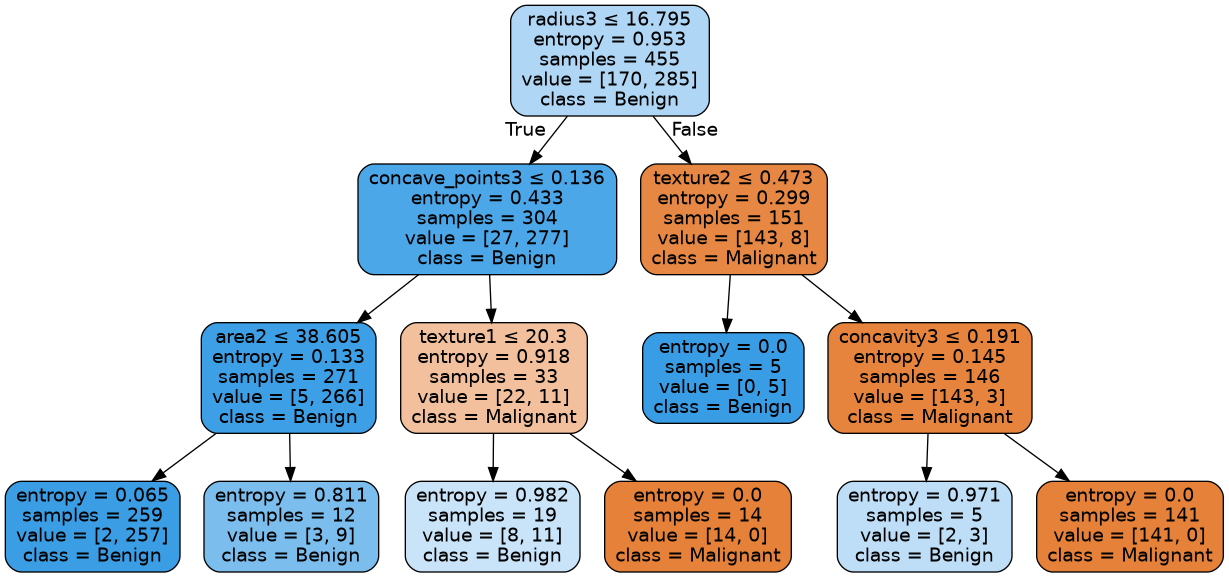

max_depth: 4


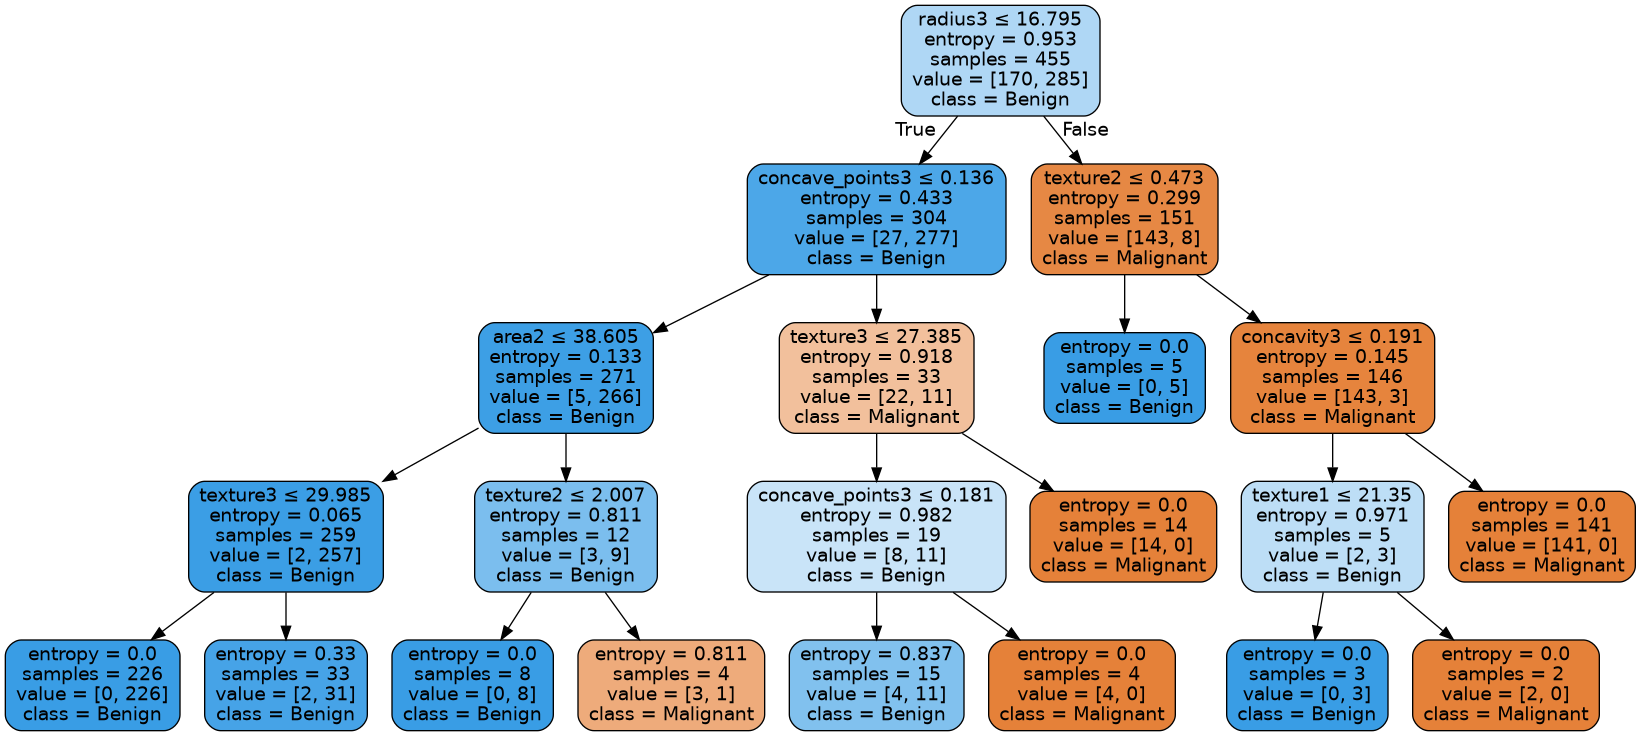

max_depth: 5


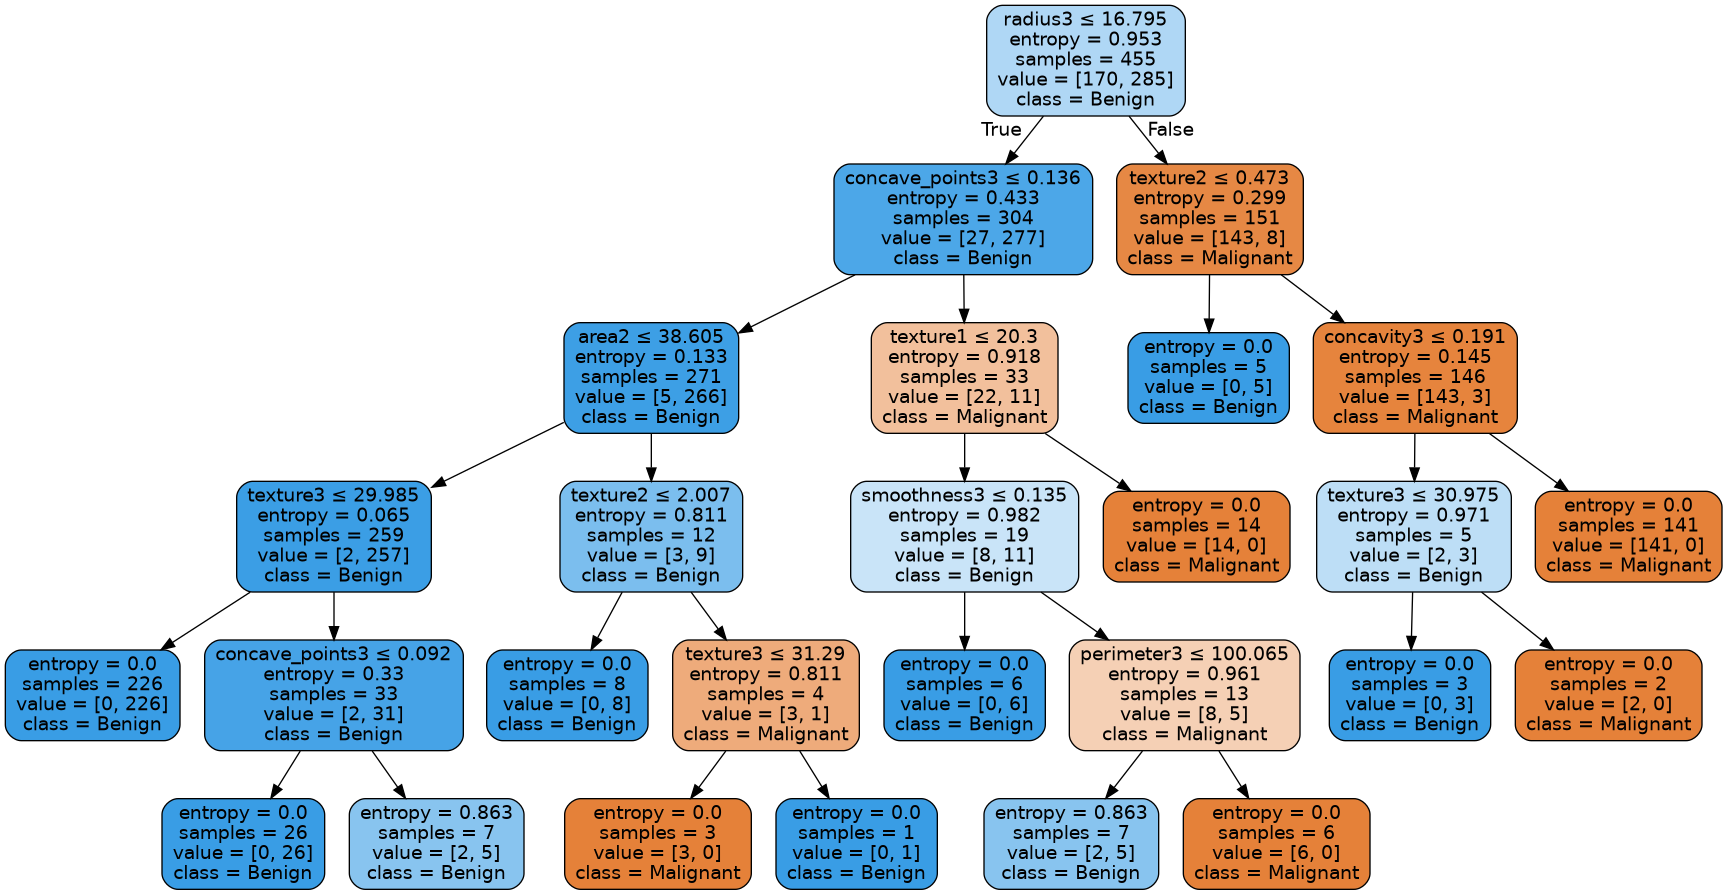

max_depth: 6


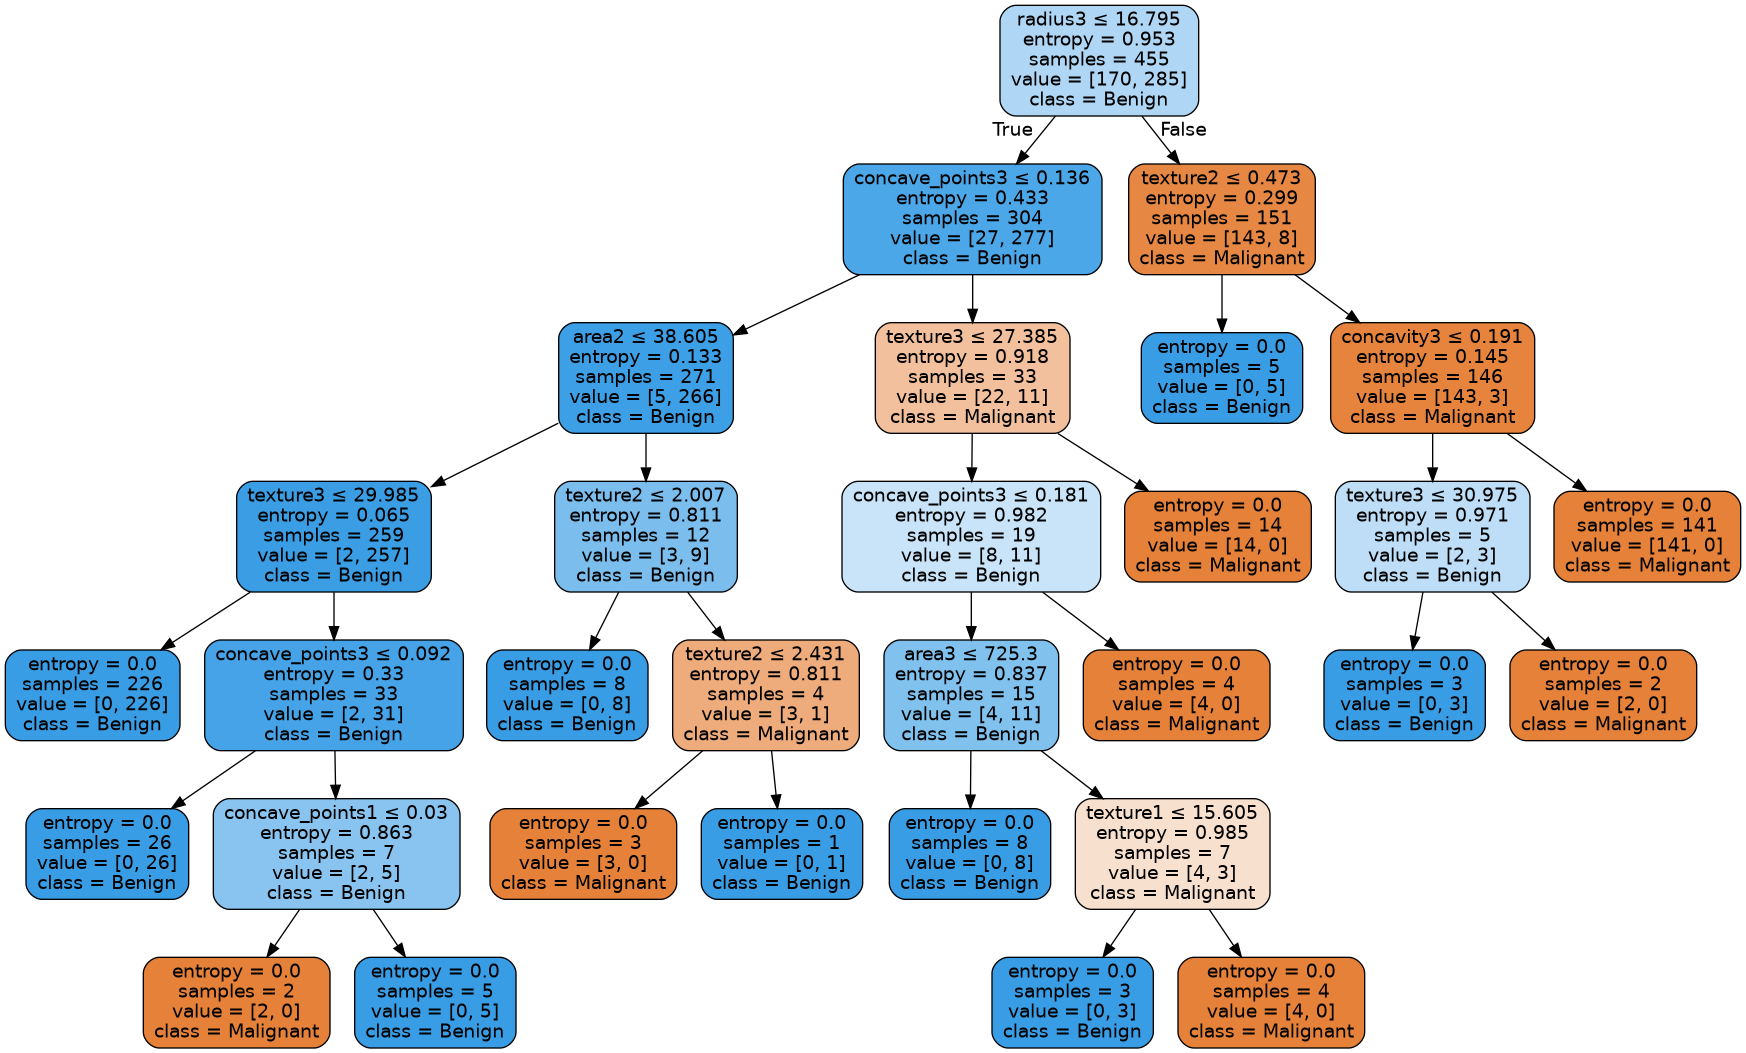

max_depth: 7


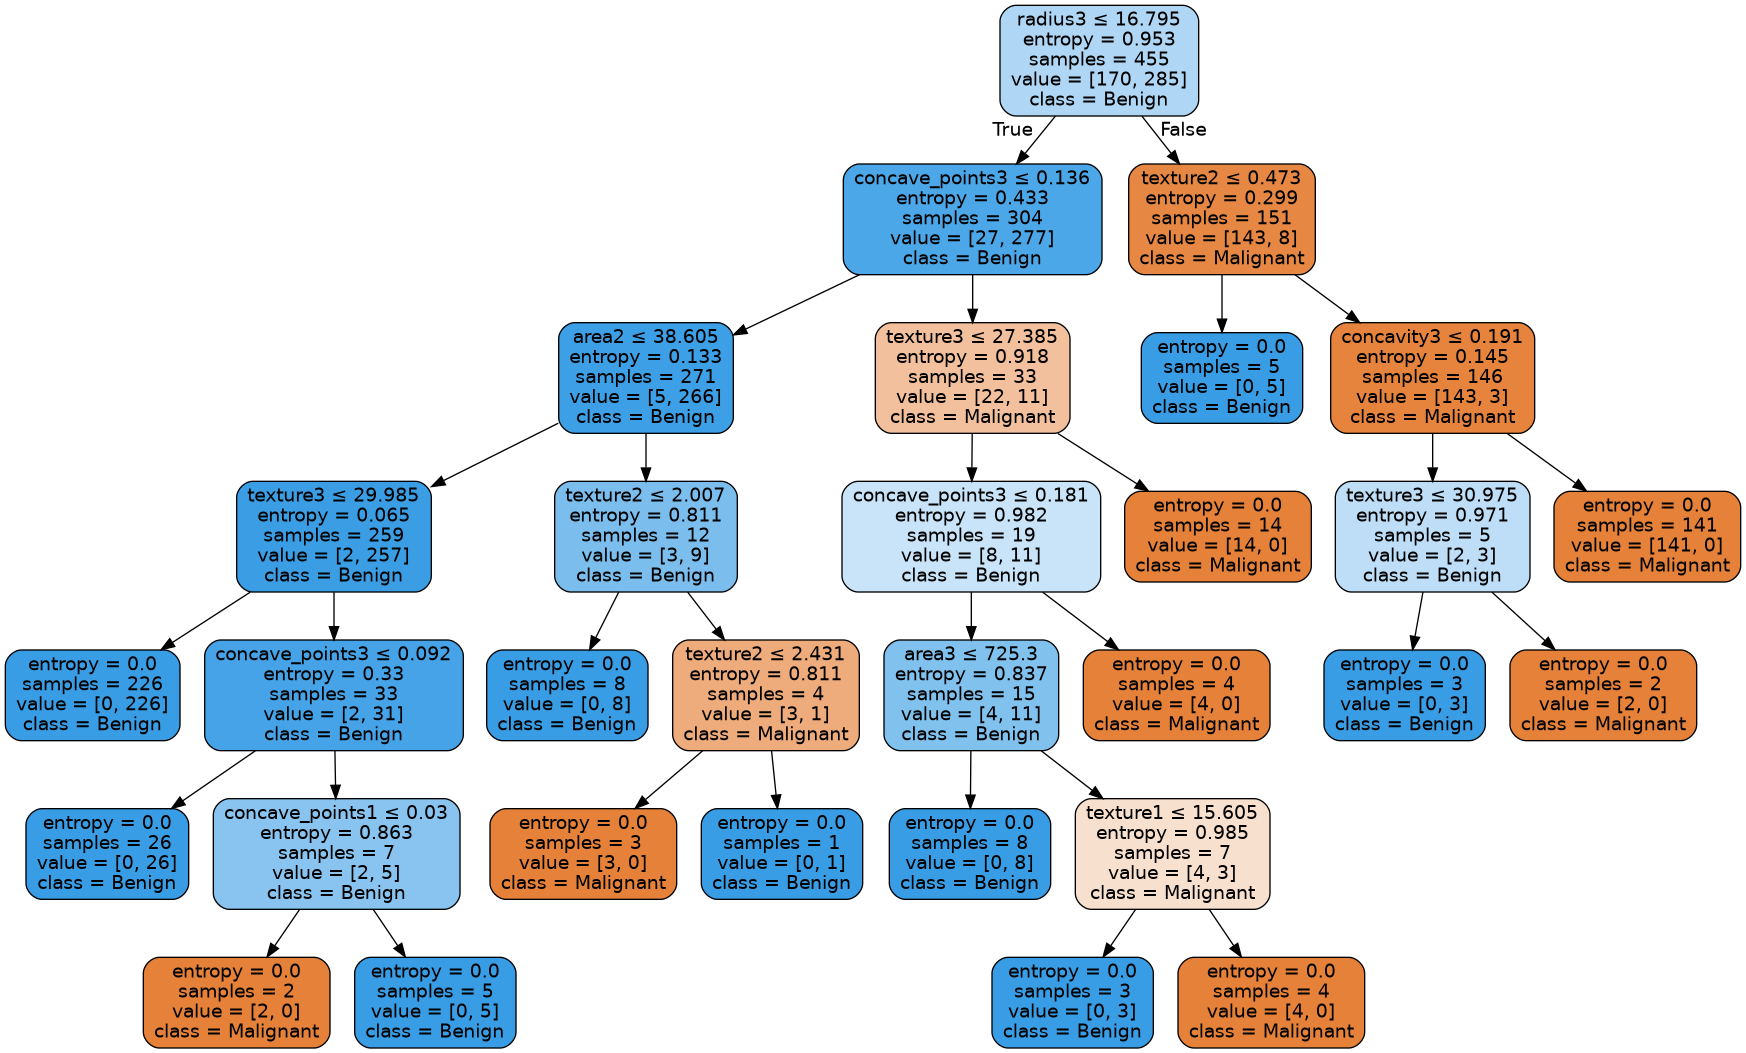

In [34]:
max_depths = [None, 2,3,4,5,6,7]
accuracy = []

for depth in max_depths:
    DT = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    DT.fit(X_train_80, y_train_80)

    y_pred_20 = DT.predict(X_test_20)
    score = accuracy_score(y_test_20, y_pred_20)
    accuracy.append({'max_depth': str(depth), 'Accuracy': score})

    print(f"max_depth: {depth}")
    file_name = f"./Image4Depths/DT_{str(depth)}"

    dot_graph = export_graphviz(
        DT, 
        out_file=None, 
        feature_names=feature_names, 
        class_names=target_names_mapping,
        filled=True, 
        rounded=True, 
        special_characters=True
    )

    graph = graphviz.Source(dot_graph)
    graph.render(filename=file_name, format="png", cleanup=True)
    display(Image(filename=file_name + '.png'))   

### b) Plot the change in accuracy

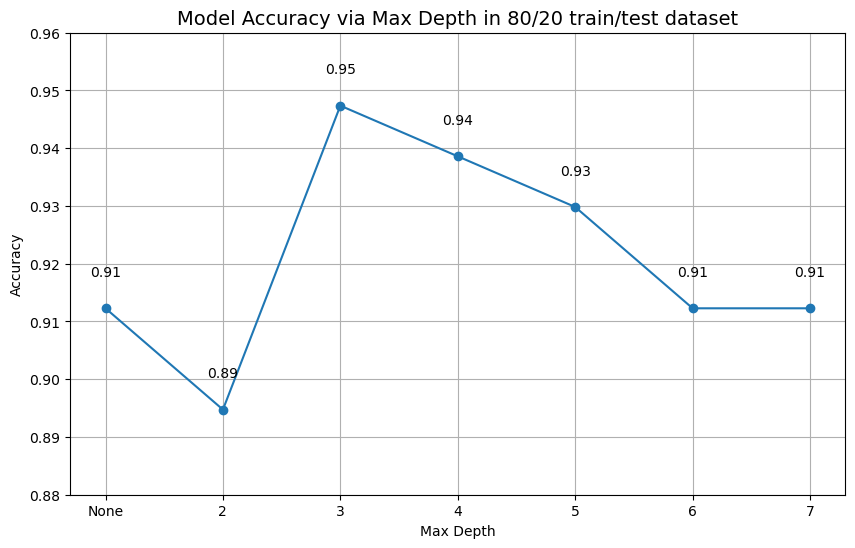

In [35]:
accuracy_df = pd.DataFrame(accuracy)

plt.figure(figsize=(10, 6))  
plt.plot(accuracy_df['max_depth'], accuracy_df['Accuracy'], marker='o')  
plt.title('Model Accuracy via Max Depth in 80/20 train/test dataset', fontsize=14)  
plt.xlabel('Max Depth')  
plt.ylabel('Accuracy')    
plt.ylim([0.88, 0.96])  
for i, acc in zip(accuracy_df['Accuracy'].index, accuracy_df['Accuracy']):  
    plt.text(accuracy_df['max_depth'][i], acc + 0.005, f"{acc:.2f}", ha='center', va='bottom')
plt.grid(True);